## Load Packages

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from statsmodels.formula.api import ols
from scipy.stats import gaussian_kde
import scipy
import scipy.sparse
import patsy
from statistics import median
import bz2
import math

## Load Data

The model data has already been pre-processed from text files and saved into pickle files. Loading and parsing the raw files (parsing ASCII text into numbers, dates, and other python data types) is intrinsically a slow operation. It can be advantageous to do this parsing once, and then use the pickle library to save the data into binary files. If the files are more than a few megabytes, you should consider using compression to avoid filling up your disk. 

In [2]:
model_dir = '/Users/gordonritter/Dropbox/teaching/barra_pickle/'

def sort_cols(test): 
    return(test.reindex(sorted(test.columns), axis=1))

frames = {}
for year in [2004,2005,2006]:
    fil = model_dir + "pandas-frames." + str(year) + ".pickle.bz2"
    frames.update(pickle.load( bz2.open( fil, "rb" ) ))

for x in frames: 
    frames[x] = sort_cols(frames[x])
    
covariance = {}
for year in [2003,2004,2005,2006]:
    fil = model_dir + "covariance." + str(year) + ".pickle.bz2"
    covariance.update(pickle.load( bz2.open(fil, "rb" ) ))

## Data Cleaning and Winsorization

The distribution of many statistics can be heavily influenced by outliers. A simple approach to robustifying parameter estimation procedures is to set all outliers to a specified percentile of the data; for example, a 90% winsorization would see all data below the 5th percentile set to the 5th percentile, and data above the 95th percentile set to the 95th percentile. Winsorized estimators are usually more robust to outliers than their more standard forms.

In [4]:
def wins(x,a,b):
    return(np.where(x <= a,a, np.where(x >= b, b, x)))

def clean_nas(df): 
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    for numeric_column in numeric_columns: 
        df[numeric_column] = np.nan_to_num(df[numeric_column])
    
    return df

We can check the distribution of returns with a density plot, both before and after winsorization to observe the effect of trimming the tails. Before any kind of winsorization, the returns can be observed to have a very heavy right tail. 

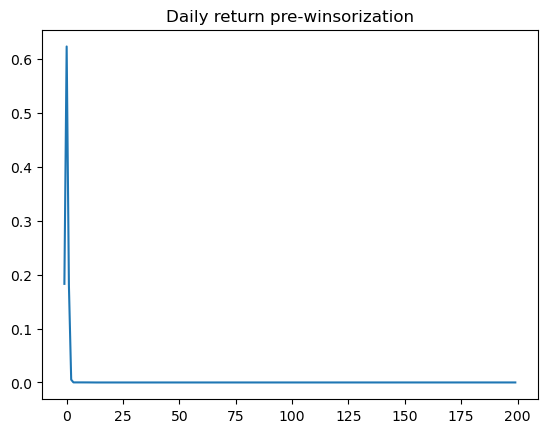

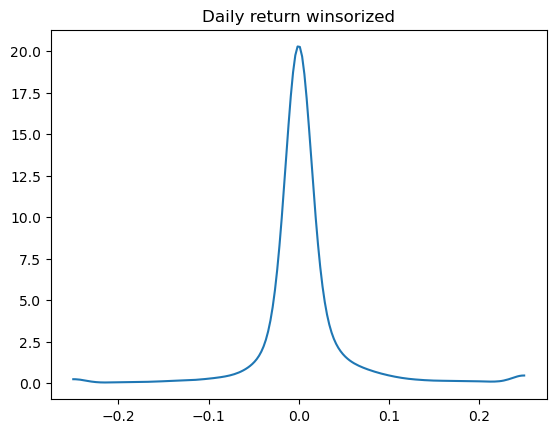

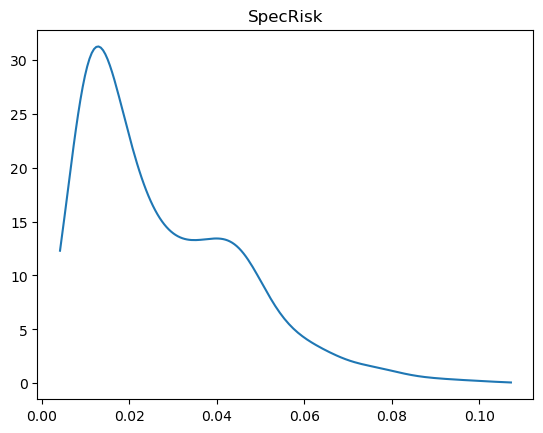

In [12]:
def density_plot(data, title): 
    density = gaussian_kde(data)
    xs = np.linspace(np.min(data),np.max(data),200)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    plt.plot(xs,density(xs))
    plt.title(title)
    plt.show()
    
test = frames['20040102']
density_plot(test['Ret'], 'Daily return pre-winsorization')
density_plot(wins(test['Ret'],-0.25,0.25), 'Daily return winsorized')
density_plot(test['SpecRisk'] / (100 * math.sqrt(252)), 'SpecRisk')

# Data definitions

ID: a unique identifier that can be used to link stocks across time 

1DREVRSL: very short-term reversal, potential alpha factor but probably too fast-moving to be tradable 

STREVRSL: short-term reversal, potential alpha factor 

LTREVRSL: long-term reversal, potential alpha factor 

BETA: risk factor computed from CAPM beta regression

EARNQLTY: earnings quality, potential alpha factor 

EARNYILD: earnings yield (blend of forecasted earnings and historical earnings divided by market cap) 

GROWTH: mix of historical and forecasted earnings growth 

LEVERAGE: financial leverage of the company's balance sheet, usually a risk factor 

LIQUIDTY: factor with high loadings for very liquidly traded names; usually a risk factor 

MGMTQLTY: management quality, potential alpha factor which looks at quantitative measures of how well-run a company is by its management 

MOMENTUM: 12-month growth in stock price, usually a risk factor 

PROFIT: profitability, potential alpha factor 

PROSPECT: based on skewness of the return distribution, potential risk factor 

RESVOL: risk factor computed from residual volatility 

SEASON: seasonality-based alpha factor 

SENTMT: news sentiment alpha factor 

SIZE: risk factor based on log(market capitalization) 

VALUE: risk factor based on ratio of tangible book value to current price 




SpecRisk: specific risk is another name for predicted residual volatility. We called this the D matrix in our discussion of APT models. 

TotalRisk: predicted total vol, including factor and idiosyncratic contributions, annualized 

Ret: asset's total return on the next day after the factor loadings are known, suitable as the Y vector in a regression analysis 

Yield: the dividend yield of the asset 


HistBeta: historically estimated CAPM beta coefficient 
PredBeta: model-predicted beta coefficient in the future 


INDMOM: industry momentum (defined as relative historical outperformance or underperformance of the other stocks in the same industry) 

IssuerMarketCap: aggregate market capitalization of the company (all share classes from the same issuer, e.g. for Google would include both Alphabet A and C) 

BidAskSpread: bid-offer spread (average for the day) 

CompositeVolume: composite trading volume for the day 

DataDate: the date when the data would have been known, as of the close 

Many of the remaining columns are industry factors, of which a full list is given below. 

In [13]:
industry_factors = ['AERODEF', 'AIRLINES', 'ALUMSTEL', 'APPAREL', 'AUTO',
       'BANKS','BEVTOB', 'BIOLIFE', 'BLDGPROD','CHEM', 'CNSTENG', 'CNSTMACH', 'CNSTMATL', 'COMMEQP', 'COMPELEC',
       'COMSVCS', 'CONGLOM', 'CONTAINR', 'DISTRIB',
       'DIVFIN', 'DIVYILD', 'ELECEQP', 'ELECUTIL', 'FOODPROD', 'FOODRET', 'GASUTIL',
       'HLTHEQP', 'HLTHSVCS', 'HOMEBLDG', 'HOUSEDUR','INDMACH', 'INSURNCE', 'INTERNET', 
        'LEISPROD', 'LEISSVCS', 'LIFEINS', 'MEDIA', 'MGDHLTH','MULTUTIL',
       'OILGSCON', 'OILGSDRL', 'OILGSEQP', 'OILGSEXP', 'PAPER', 'PHARMA',
       'PRECMTLS','PSNLPROD','REALEST',
       'RESTAUR', 'ROADRAIL','SEMICOND', 'SEMIEQP','SOFTWARE', 'SPLTYRET', 'SPTYCHEM', 'SPTYSTOR',
       'TELECOM', 'TRADECO', 'TRANSPRT', 'WIRELESS']

style_factors = ['BETA','SIZE','MOMENTUM','VALUE']

def get_formula(alpha):
    L = ["0", alpha]
    L.extend(style_factors)
    L.extend(industry_factors)
    return "Ret ~ " + " + ".join(L)

## Homework problems

To evaluate a potential alpha factor, we can analyze the factor returns which come from a time series of cross sectional regressions as discussed in lecture. 

### Problem 1. 

Write a function called "estimate_factor_returns" which takes as arguments, an alpha factor name, and an input data frame "df". The function must not modify the contents of the data frame. The function will first subset to IssuerMarketCap > 1e9 to obtain a liquid universe, and then run an OLS regression using the formula returned by the get_formula function defined above. The dependent variable in the regression must be winsorized return, using the winsorisation procedure discussed above in this notebook. The estimate_factor_returns function should return an object which, at very least, contains the slope coefficients from the regression, and may contain other information. 

### Problem 2. 

Write a function which iteratively calls estimate_factor_returns on every data frame in the dictionary called "frames" above, and returns a univariate time series containing the coefficient on the alpha factor for each date. Since only the alpha factor return is saved, style and industry factor returns are discarded by this procedure. 

### Problem 3. 

For each of the potential alpha factors STREVRSL, PROFIT, SENTMT, run the function created in Problem 2 and plot the cumulative sum of the resulting time series. Do any of these qualify as potential alpha factors? Do the cumulative returns from the plot represent returns on any tradable assets or portfolios? 